# 🧠 Stereo Vision Coursework: Reconstructing 3D from Two Views

Welcome to your stereo vision mini-project.

In this coursework, you will build a **complete stereo vision pipeline** from scratch.  
You’ll start by simulating a 3D object (a rectangular box), project it into the views of two virtual cameras,  
then recover the 3D geometry of the object using camera calibration, triangulation, and disparity-based depth estimation.

Everything will be implemented using only `NumPy` and `Matplotlib`,  
with clear, step-by-step guidance — no black-box libraries.

---

## 🎯 Learning Outcomes

By completing this notebook, you will be able to:

- Understand the **pinhole camera model** and its projection matrix
- Use **3D–2D correspondences** to estimate a camera projection matrix using the **DLT algorithm**
- **Decompose** the projection matrix to extract intrinsics and extrinsics
- Compute **disparity** from stereo projections and use it to estimate **depth**
- Reconstruct the full **3D coordinates** of points from image + depth
- Visualize and **evaluate reconstruction accuracy** using RMSE and recovered dimensions

---

## 🛠️ What You Will Build

We will construct the pipeline step-by-step:

1. **Simulate a 3D object**: Create a known 3D rectangular box with exact dimensions.
2. **Define stereo camera setup**: Left and right camera with known intrinsics and baseline.
3. **Project 3D points to both views**: Use known intrinsics and extrinsics to simulate images.
4. **Calibrate cameras from 3D–2D pairs**: Use Direct Linear Transform (DLT) to estimate projection matrices.
5. **Decompose the projection matrices**: Recover the intrinsic matrix `K`, rotation `R`, and translation `t`.
6. **Compute disparity**: Measure horizontal displacement between matching points in left/right images.
7. **Estimate depth**: Apply triangulation formula using estimated `f` and `B`.
8. **Back-project to 3D**: Recover 3D coordinates using depth and left image projection.
9. **Evaluate the reconstruction**: Report RMSE and compare recovered box dimensions to ground truth.
10. **Visualize 3D structure and projections**: Compare original vs. reconstructed 3D edges and projected lines in both views.

---

## 📦 Coursework Format

This notebook follows a structured format with clearly separated:

- ✅ **Provided code** — do not modify unless instructed.
- ✏️ **TODO blocks** — you are required to complete these.
- 📊 **Self-checks and visualizations** — interpret the outputs to evaluate your work.

The coursework is self-contained, and all the mathematical and implementation steps will be explained in detail.

---

> ⚠️ **Important**: After the calibration step, you must rely only on the **estimated** camera parameters —  
do **not** use the original ground-truth intrinsics/extrinsics for the reconstruction or depth estimation.  
This models a real-world scenario where only image correspondences are available.

---

Let’s begin!


## Step 1 — Simulate a 3D Object in Space

Before working with cameras, we define a **simple synthetic 3D object** to serve as our known ground truth.

We use a **rectangular box (cuboid)** described by 8 corner points in 3D space. This will later be projected into each camera view and reconstructed from stereo geometry.

---

### 🔧 What You’re Given

In this step, you are provided with:

- The **box dimensions** (width, height, depth)
- The 3D coordinates of the box corners in **local coordinates**
- A function to **check the geometry** and a visualization to confirm correctness

---

### 📌 What You Should Do

✅ **Nothing to implement here** — this setup is already complete.

However, you should:

1. **Run the cell** and inspect the 3D plot  
2. Make sure the box is centered at $X = 0$, $Y = 0$, and starts at $Z = 2$  
3. Confirm that the wireframe and corner vertices look correct  
4. Read and understand the structure of the code, as you will build on this in the next steps

This step lays the foundation for projection and depth recovery, so make sure you're comfortable with the box geometry before moving on.


Geometry check: PASS


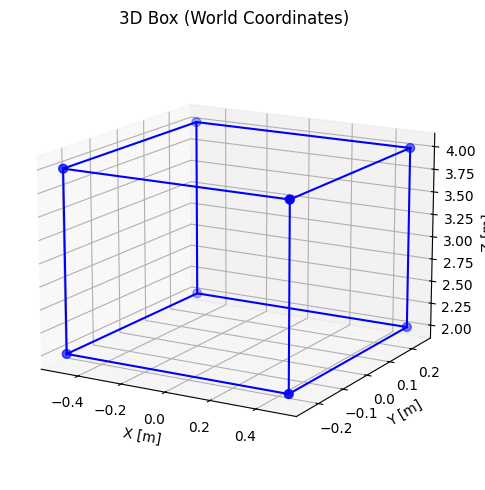

In [ ]:
# ============================================================
# 🧊 STEP 1 — Simulate a 3D Box in Space
# ============================================================

# In this step, we simulate a known 3D object — a rectangular box —
# to serve as ground truth for the stereo vision pipeline.

import numpy as np
import matplotlib.pyplot as plt

# ------------------------------------------------------------
# ✅ GIVEN: Ground-truth dimensions of the 3D box (in meters)
# ------------------------------------------------------------
W = 1.0  # width along X-axis
H = 0.5  # height along Y-axis
D = 2.0  # depth along Z-axis

# ------------------------------------------------------------
# ✅ GIVEN: Local 3D coordinates of the box corners
# ------------------------------------------------------------
box_vertices_local = np.array([
    [0, 0, 0],     # front-bottom-left
    [W, 0, 0],     # front-bottom-right
    [W, H, 0],     # front-top-right
    [0, H, 0],     # front-top-left
    [0, 0, D],     # back-bottom-left
    [W, 0, D],     # back-bottom-right
    [W, H, D],     # back-top-right
    [0, H, D],     # back-top-left
])

# ------------------------------------------------------------
# ✅ GIVEN: Offset to place the box in front of both cameras
# ------------------------------------------------------------
offset = np.array([-W / 2, -H / 2, 2.0])  # center in XY, push forward in Z

# ------------------------------------------------------------
# ✅ APPLY: Offset to get world coordinates of the box
# ------------------------------------------------------------
box_vertices = box_vertices_local + offset  # shape: (8, 3)

# ------------------------------------------------------------
# ✅ GIVEN: Wireframe edge connections (for visualization)
# ------------------------------------------------------------
edges = [
    (0, 1), (1, 2), (2, 3), (3, 0),  # front face
    (4, 5), (5, 6), (6, 7), (7, 4),  # back face
    (0, 4), (1, 5), (2, 6), (3, 7)   # connecting sides
]

# ------------------------------------------------------------
# ✅ CHECK: Sanity check for box geometry
# ------------------------------------------------------------
def box_geometry_check(vertices, W, H, D):
    ok = True
    ok &= (vertices.shape == (8, 3))
    ok &= (np.all(vertices[:, 2] > 0))  # all Z values must be positive
    tol = 1e-9
    ok &= np.abs(np.ptp(vertices[:, 0]) - W) < tol
    ok &= np.abs(np.ptp(vertices[:, 1]) - H) < tol
    ok &= np.abs(np.ptp(vertices[:, 2]) - D) < tol
    return ok

print("Geometry check:", "PASS" if box_geometry_check(box_vertices, W, H, D) else "FAIL")

# ------------------------------------------------------------
# ✅ VISUALIZE: 3D Box and its edges
# ------------------------------------------------------------
fig = plt.figure(figsize=(6, 5))
ax = fig.add_subplot(111, projection='3d')

for i, j in edges:
    ax.plot(*zip(box_vertices[i], box_vertices[j]), color='blue')

ax.scatter(*box_vertices.T, color='blue', s=40)

ax.set_xlabel("X [m]")
ax.set_ylabel("Y [m]")
ax.set_zlabel("Z [m]")
ax.set_title("3D Box (World Coordinates)")
ax.view_init(elev=15, azim=-60)
plt.tight_layout()
plt.show()


## Step 2 — Define the Stereo Camera Setup and Project the 3D Scene

Now that we have a 3D box defined in world coordinates, we simulate how it is viewed by a **stereo camera system** — a pair of cameras placed side‑by‑side, looking in the same direction.

Our goal is to mathematically model the stereo setup and **project the 3D box** into 2D image planes (left and right views) using camera projection matrices.

---

### 🧠 2.1 What Is a Projection Matrix?

In computer vision, a **projection matrix** transforms a 3D point $(X, Y, Z)$ into a 2D pixel location $(u, v)$:

$$
\begin{bmatrix}
u \\ v \\ w
\end{bmatrix}
=
P \cdot
\begin{bmatrix}
X \\ Y \\ Z \\ 1
\end{bmatrix}
\quad \Rightarrow \quad
(u', v') = \left( \frac{u}{w},\, \frac{v}{w} \right)
$$

The projection matrix $P$ combines both **intrinsics** and **extrinsics**:

$$
P = K \cdot [R \mid \mathbf{t}]
$$

Where:

- $K$ is the **intrinsic matrix** (focal length, principal point)
- $[R \mid \mathbf{t}]$ is the **extrinsic matrix** (rotation + translation from world to camera)

---

### 🎥 2.2 Our Stereo Setup

We simulate a **rectified stereo pair**:

- Both cameras share the same optical axis
- Left camera is at the origin
- Right camera is shifted **horizontally** by baseline $B = 0.2$ m

Their intrinsics are:

$$
f = 200~\text{pixels},\quad c_x = c_y = 0
$$

So:

$$
K =
\begin{bmatrix}
200 & 0 & 0 \\
0 & 200 & 0 \\
0 & 0 & 1
\end{bmatrix}
$$

Extrinsics:

- $R = I$ for both
- $t_{\text{left}} = [0, 0, 0]^T$
- $t_{\text{right}} = [-B, 0, 0]^T$

---

### ✍️ Your Tasks in This Step

In this step, you will:

1. **Implement a function** to compute the full 3×4 projection matrix from given `K`, `R`, and `t`
2. **Build the projection matrices** for both cameras using this function
3. **Implement a function** to project 3D points into 2D image coordinates using a projection matrix
4. **Project** the 3D box into both views
5. **Visualize** the projections using the given helper

This projection step mimics what a real stereo camera does to view a 3D scene.


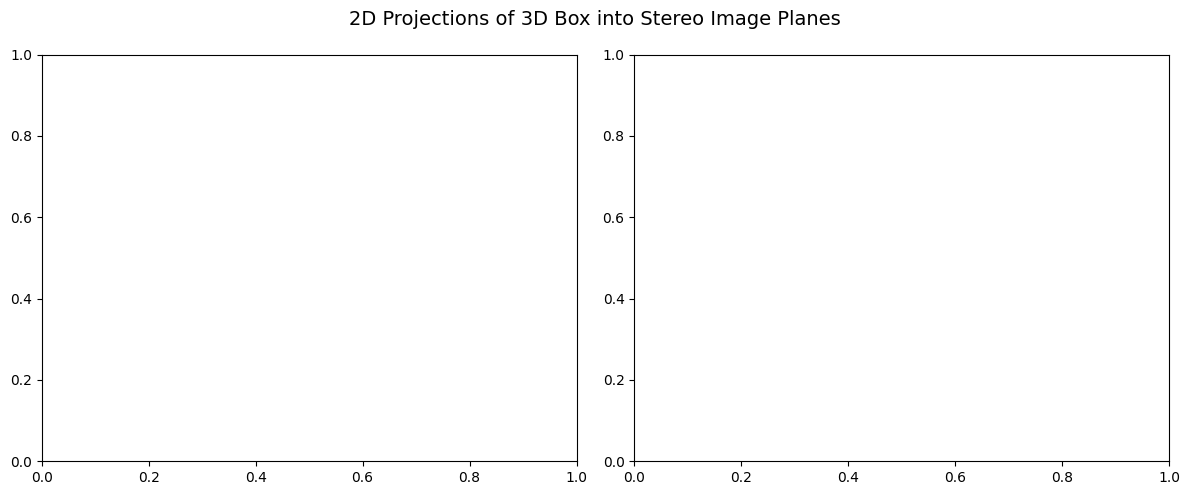

In [ ]:
# ============================================================
# STEP 2 — Define Stereo Cameras and Project 3D Box into Views
# ============================================================

import numpy as np
import matplotlib.pyplot as plt

# ------------------------------------------------------------
# ✅ GIVEN: Camera Intrinsics (shared by both cameras)
# ------------------------------------------------------------
f = 200.0  # focal length in pixels
cx = 0.0   # principal point u
cy = 0.0   # principal point v

K = np.array([
    [f, 0, cx],
    [0, f, cy],
    [0, 0, 1]
])

# ------------------------------------------------------------
# ✅ GIVEN: Camera Extrinsics
# ------------------------------------------------------------
R = np.eye(3)                   # Identity rotation
B = 0.2                         # Baseline in meters

t_left  = np.array([[0], [0], [0]])         # Left camera
t_right = np.array([[-B], [0], [0]])        # Right camera (shifted in X)

# ------------------------------------------------------------
# 📌 TODO: Implement the Projection Matrix Constructor
# ------------------------------------------------------------
def make_projection_matrix(K, R, t):
    """
    Constructs the full 3×4 camera projection matrix from intrinsics (K),
    rotation (R), and translation (t):
        P = K [R | t]
    """
    # TODO: Horizontally stack R and t to form [R | t]
    # TODO: Multiply K by [R | t] to obtain the projection matrix P
    # TODO: Return P
    pass  # Remove this once implemented

# ------------------------------------------------------------
# 📌 TODO: Create Projection Matrices for Left and Right Cameras
# ------------------------------------------------------------
# Hint: use your make_projection_matrix(K, R, t_left) and t_right
# P_left  = ...
# P_right = ...
pass  # Remove this once implemented

# ------------------------------------------------------------
# 📌 TODO: Implement the Projection Function for 3D → 2D Mapping
# ------------------------------------------------------------
def project_points(P, points_3D):
    """
    Projects 3D points into 2D image coordinates using projection matrix P.

    Args:
        P: (3, 4) projection matrix
        points_3D: (N, 3) array of 3D points

    Returns:
        (N, 2) array of 2D image coordinates
    """
    # TODO: Determine the number of points N
    # TODO: Convert points_3D to homogeneous coordinates by appending 1s
    # TODO: Multiply by the projection matrix P
    # TODO: Normalize by the third coordinate (divide by w)
    # TODO: Return the resulting (u, v) coordinates
    pass  # Remove this once implemented

# ------------------------------------------------------------
# 📌 TODO: Project the 3D Box into Left and Right Image Planes
# ------------------------------------------------------------
# uv_left  = project_points(P_left, box_vertices)
# uv_right = project_points(P_right, box_vertices)
pass  # Remove this once implemented

# ------------------------------------------------------------
# ✅ VISUALIZE: Both left and right projections with edges
# ------------------------------------------------------------
def plot_projection(ax, uv, title, color, edge_list):
    # Plot vertices
    ax.scatter(uv[:, 0], uv[:, 1], s=50, marker='o', color=color, label='Vertices')

    # Draw projected edges
    for i, j in edge_list:
        pt1, pt2 = uv[i], uv[j]
        ax.plot([pt1[0], pt2[0]], [pt1[1], pt2[1]], color=color, linestyle='-', linewidth=1)

    # Format plot
    ax.set_title(title)
    ax.set_xlabel("$u$ [px]")
    ax.set_ylabel("$v$ [px]")
    ax.axis("equal")
    ax.grid(True)
    ax.legend(loc='upper right')

# Show both views
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# TODO: Uncomment once uv_left and uv_right are computed
# plot_projection(axes[0], uv_left, "Left Camera Projection", color='blue', edge_list=edges)
# plot_projection(axes[1], uv_right, "Right Camera Projection", color='red', edge_list=edges)

plt.suptitle("2D Projections of 3D Box into Stereo Image Planes", fontsize=14)
plt.tight_layout()
plt.show()



## Step 3 — Estimate Camera Projection Matrices from 3D–2D Correspondences

In practice, we rarely know the camera projection matrix $P$ directly.  
Instead, we estimate it from **known 3D–2D correspondences** using a method called the **Direct Linear Transform (DLT)** algorithm.

---

### 🧠 What Is the DLT?

You are given a set of:

- 3D points: $\mathbf{X}_i = [X_i, Y_i, Z_i]^\top$
- 2D points: $\mathbf{x}_i = [u_i, v_i]^\top$

The goal is to find a projection matrix $P \in \mathbb{R}^{3 \times 4}$ such that:

$$
\begin{bmatrix}
u_i \\ v_i \\ 1
\end{bmatrix}
\approx
P \cdot
\begin{bmatrix}
X_i \\ Y_i \\ Z_i \\ 1
\end{bmatrix}
$$

---

### ⚙️ DLT Internals (for your understanding only)

Each correspondence pair adds two linear equations.  
Stacking all $N$ correspondences gives a system:

$$
A \cdot \mathbf{p} = 0
$$

Where:

- $A$ is a $2N \times 12$ matrix
- $\mathbf{p}$ is a 12-vector containing the unknown entries of $P$

Solving this system via **SVD** gives the best-fit $\mathbf{p}$ — the last column of $V^\top$.  
Reshaping it gives the estimated $3 \times 4$ projection matrix.

---

### 🛠️ Your Task

You are provided with a function that performs this calibration for you.  
It estimates the projection matrix using DLT and is already implemented.

✅ Your task:

- Use this function to estimate:
  - $P_{\text{left}}$ using `box_vertices` and `uv_left`
  - $P_{\text{right}}$ using `box_vertices` and `uv_right`
- Print both estimated projection matrices

These estimates will be used in all the following steps to simulate realistic depth recovery.


In [ ]:
# ============================================================
# STEP 3 — Estimate Camera Projection Matrices from 3D–2D Pairs
# ============================================================

import numpy as np

# ------------------------------------------------------------
# ✅ GIVEN: A helper function to estimate projection matrix via DLT
# ------------------------------------------------------------
# This function is already implemented for you.
# You can call it as: calibrate_camera(pts_3D, pts_2D)
# It returns a 3×4 projection matrix P.

def calibrate_camera(pts_3D: np.ndarray, pts_2D: np.ndarray) -> np.ndarray:
    """
    (Already implemented for you — DO NOT MODIFY)

    Estimate the 3×4 projection matrix P from at least 6 correspondences
    between 3D world points and 2D image points using the Direct Linear Transform (DLT).

    Args:
        pts_3D: (N, 3) array of 3D world coordinates
        pts_2D: (N, 2) array of corresponding 2D image coordinates

    Returns:
        P: (3, 4) normalized projection matrix
    """
    assert pts_3D.shape[0] == pts_2D.shape[0], "3D and 2D point sets must match in number."
    N = pts_3D.shape[0]
    A = []

    for i in range(N):
        X, Y, Z = pts_3D[i]
        u, v = pts_2D[i]

        # Two equations per correspondence
        A.append([X, Y, Z, 1, 0, 0, 0, 0, -u*X, -u*Y, -u*Z, -u])
        A.append([0, 0, 0, 0, X, Y, Z, 1, -v*X, -v*Y, -v*Z, -v])

    A = np.array(A)  # Shape: (2N, 12)

    # ------------------------------------------------------------
    # ✅ Solve A p = 0 using SVD → last column of V^T gives solution
    # ------------------------------------------------------------
    _, _, Vt = np.linalg.svd(A)
    P = Vt[-1].reshape(3, 4)

    # ------------------------------------------------------------
    # ✅ Normalize P to remove arbitrary projective scale ambiguity
    # ------------------------------------------------------------
    if np.linalg.norm(P[-1]) != 0:
        P = P / np.linalg.norm(P[-1])

    return P

# ------------------------------------------------------------
# 📌 TODO: Estimate the projection matrix for each camera
# ------------------------------------------------------------
# Use the `calibrate_camera` function to estimate P_left_est and P_right_est
# from the known 3D points (box_vertices) and their 2D projections (uv_left, uv_right)

# P_left_est  = ...
# P_right_est = ...
pass  # Remove once implemented

# ------------------------------------------------------------
# ✅ Inspect your results
# ------------------------------------------------------------
np.set_printoptions(precision=3, suppress=True)

# TODO: Uncomment after estimating
# print("Estimated Projection Matrix — Left Camera ($P_{left}^{est}$):")
# print(P_left_est)

# print("\nEstimated Projection Matrix — Right Camera ($P_{right}^{est}$):")
# print(P_right_est)


## Step 4 — Validate Estimated Projection Matrices via Reprojection

Now that we've estimated the projection matrices $P_\text{left}^{\text{est}}$ and $P_\text{right}^{\text{est}}$,  
we want to check how accurate they are.

We do this by **reprojecting** the original 3D points into the image planes using the estimated $P$ matrices, and comparing the result to the original 2D projections.

---

### 4.1 Reprojection Formula

To reproject a 3D point $\mathbf{X} = [X, Y, Z]^T$ using a $3 \times 4$ projection matrix $P$, we convert the point to homogeneous coordinates:

$$
\begin{bmatrix}
u \\
v \\
w
\end{bmatrix}
=
P \cdot
\begin{bmatrix}
X \\
Y \\
Z \\
1
\end{bmatrix}
\quad \Rightarrow \quad
(u', v') = \left( \frac{u}{w}, \frac{v}{w} \right)
$$

---

### 4.2 Reprojection Error

We compare the reprojected points $(u', v')$ to the original ones $(u, v)$ and compute the **Root Mean Squared Error (RMSE)**:

$$
\text{RMSE} = \sqrt{\frac{1}{N} \sum_{i=1}^N \left[ (u_i - u'_i)^2 + (v_i - v'_i)^2 \right]}
$$

A low RMSE indicates that the estimated $P$ matrix accurately models the projection geometry.

---

In the next cell, we will:

- Reproject the 3D points using the estimated $P$ matrices
- Visualize the original and reprojected points side-by-side
- Report the RMSE for each camera


In [ ]:
# ============================================================
# STEP 4 — Reproject 3D Points Using Estimated P Matrices
# ============================================================

import numpy as np
from scipy.linalg import rq

def reproject_points(P: np.ndarray, pts_3D: np.ndarray) -> np.ndarray:
    """
    Reproject 3D world points into 2D image coordinates using the given projection matrix.

    Args:
        P:      (3, 4) projection matrix
        pts_3D: (N, 3) array of 3D world coordinates

    Returns:
        pts_2D: (N, 2) array of 2D image coordinates
    """
    N = pts_3D.shape[0]
    pts_3D_hom = np.hstack([pts_3D, np.ones((N, 1))])  # → (N, 4)
    proj = P @ pts_3D_hom.T                            # → (3, N)
    proj /= proj[2, :]                                 # normalize by w
    return proj[:2, :].T                               # → (N, 2)

# ------------------------------------------------------------
# Reproject 3D points using estimated projection matrices
# ------------------------------------------------------------
uv_left_proj_est  = reproject_points(P_left_est, box_vertices)
uv_right_proj_est = reproject_points(P_right_est, box_vertices)

# ------------------------------------------------------------
# Compute RMSE between true and estimated 2D projections
# ------------------------------------------------------------
def compute_rmse(true_pts: np.ndarray, est_pts: np.ndarray) -> float:
    """
    Compute Root Mean Squared Error between true and estimated 2D image points.

    Args:
        true_pts: (N, 2) ground-truth image points
        est_pts:  (N, 2) estimated image points

    Returns:
        Scalar RMSE value
    """
    return np.sqrt(np.mean(np.sum((true_pts - est_pts) ** 2, axis=1)))

rmse_left  = compute_rmse(uv_left, uv_left_proj_est)
rmse_right = compute_rmse(uv_right, uv_right_proj_est)

# ------------------------------------------------------------
# Extract estimated intrinsics using RQ decomposition
# ------------------------------------------------------------
def extract_intrinsics(P: np.ndarray) -> tuple[np.ndarray, np.ndarray]:
    """
    Decompose the left 3×3 block of the projection matrix using RQ to extract:
    - K: intrinsic matrix
    - R: rotation matrix
    Returns normalized K where K[2,2] = 1
    """
    M = P[:, :3]
    K, R = rq(M)
    K /= K[2, 2]
    return K, R

K_left_est, _  = extract_intrinsics(P_left_est)
K_right_est, _ = extract_intrinsics(P_right_est)

# ------------------------------------------------------------
# Report results
# ------------------------------------------------------------
np.set_printoptions(precision=4, suppress=True)

print("🔍 Reprojection RMSE (in pixels)")
print("--------------------------------")
print(f"Left Camera:  RMSE = {rmse_left:.6f}")
print(f"Right Camera: RMSE = {rmse_right:.6f}")

print("\n📷 Estimated Intrinsic Matrix (Left Camera):")
print(K_left_est)

print("\n📷 Estimated Intrinsic Matrix (Right Camera):")
print(K_right_est)


NameError: name 'P_left_est' is not defined

## Step 5 — Recover Depth from Disparity

Now that you have:

- Reprojected the 3D points into **both camera views** using your estimated $P$ matrices,
- Established **pixel correspondences** between the left and right images,

you can now compute the **disparity** and recover the corresponding **depth $Z$** for each 3D point.

---

### 📏 What is Disparity?

Disparity refers to the **horizontal shift** of the same 3D point in the left and right images:

$$
\text{disparity}_i = u^{\text{(left)}}_i - u^{\text{(right)}}_i
$$

This is valid only because the cameras are **rectified** — their image planes are aligned horizontally.

---

### 🔁 From Disparity to Depth

Once you have the disparity, you can estimate the depth using:

$$
Z_i = \frac{f \cdot B}{\text{disparity}_i}
$$

Where:
- $f$ is the **focal length** in pixels,
- $B$ is the **baseline** in meters,
- $\text{disparity}_i$ is the horizontal difference in pixels.

---

### ⚙️ What You’ll Do

You are given the estimated 2D coordinates of each point in the left and right images.

✅ Your tasks:

1. Write one line to compute **disparity** as $u_\text{left} - u_\text{right}$
2. Write one line to compute **depth** using the triangulation formula
3. Run the provided checks to verify that:
   - Disparities are positive
   - Depth values are finite
   - Your estimated disparities roughly match the expected ones

These depth values will be used in the final 3D reconstruction step.


In [ ]:
# ============================================================
# STEP 5 — Compute Disparity and Recover Depth
# ============================================================

# ------------------------------------------------------------
# ✅ GIVEN: Use focal length from intrinsics
# ------------------------------------------------------------
fx = f  # focal length in pixels

# ------------------------------------------------------------
# ✅ GIVEN: Extract horizontal pixel coordinates from 2D projections
# ------------------------------------------------------------
u_left_est  = uv_left_proj_est[:, 0]   # (N,) from left estimated projection
u_right_est = uv_right_proj_est[:, 0]  # (N,) from right estimated projection

# ------------------------------------------------------------
# 📌 TODO 1: Compute disparity (u_left - u_right)
# ------------------------------------------------------------
# Write one line to compute disparity using the horizontal coordinates
# Hint: disparity is the horizontal shift between the same 3D point in left and right images
disparity = None  # TODO: replace None with your expression

# ------------------------------------------------------------
# ✅ GIVEN: Avoid divide-by-zero using epsilon
# ------------------------------------------------------------
eps = 1e-9
disparity_safe = np.where(np.abs(disparity) < eps, eps, disparity)

# ------------------------------------------------------------
# 📌 TODO 2: Compute depth using the triangulation formula
# ------------------------------------------------------------
# Formula: Z = (f * B) / disparity
# Write one line to compute depth (Z_rec)
Z_rec = None  # TODO: replace None with your expression

# ------------------------------------------------------------
# ✅ GIVEN: Sanity Checks — Interpretation and Debugging
# ------------------------------------------------------------
Z_front_true = box_vertices[:4, 2].mean()  # average Z of front face
expected_front_disp = fx * B / Z_front_true
actual_front_disp = disparity[:4].mean()

# ✅ Diagnostic outputs
print("✅ Disparities positive?         ", np.all(disparity > 0))
print("✅ Depth values finite?          ", np.all(np.isfinite(Z_rec)))
print(f"🔍 Expected disparity (front):   {expected_front_disp:.4f} pixels")
print(f"🔍 Actual disparity (front):     {actual_front_disp:.4f} pixels")


## Step 6 — Visualize Disparity and Recovered Depth

Now that we have recovered the **disparity** and **depth** for each 3D point using stereo geometry,  
it is important to **visualize** these values to:

- Understand how disparity varies across the object.
- See how disparity translates into depth.
- Spot any anomalies (e.g., zero or negative disparities, unexpected depth values).

---

### 6.1 What Should We Expect?

- Disparity values should be **positive**  
  (i.e., the $u$-coordinate in the **left** image should be greater than in the **right**).
  
- Points on the **front face** of the box (closer to the camera) should have **larger disparity**.

- Points on the **back face** (farther from the camera) should have **smaller disparity**.

- The recovered depth $Z$ should be:
  $$
  Z = \frac{f \cdot B}{\text{disparity}} \quad \text{(in meters)}
  $$

  So disparity and depth are **inversely related**.

---

### 6.2 Visualisation Strategy

We will use two bar plots:

1. **Disparity plot**: bar height represents disparity (in pixels)  
2. **Depth plot**: bar height represents depth $Z$ (in meters)

Each bar corresponds to one of the **8 box vertices**, labelled from `P0` to `P7`.

These visualizations will help you verify if the reconstruction behaves as expected.


In [ ]:
# ============================================================
# STEP 6 — Visualize Disparity and Recovered Depth
# ============================================================

import matplotlib.pyplot as plt

# Vertex labels
vertex_labels = [f"P{i}" for i in range(8)]

# ------------------------------------------------------------
# Create a bar plot for disparity
# ------------------------------------------------------------
plt.figure(figsize=(10, 4))
plt.bar(vertex_labels, disparity, color='skyblue', edgecolor='black')
plt.ylabel("Disparity [pixels]")
plt.title("Disparity for Each 3D Box Vertex")
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# ------------------------------------------------------------
# Create a bar plot for recovered depth
# ------------------------------------------------------------
plt.figure(figsize=(10, 4))
plt.bar(vertex_labels, Z_rec, color='lightgreen', edgecolor='black')
plt.ylabel("Recovered Depth Z [meters]")
plt.title("Estimated Depth for Each 3D Box Vertex")
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


## Step 7 — Reconstruct 3D Coordinates from Left Image and Depth

Now that we have the **depth** $Z$ of each 3D point and its 2D projection $(u, v)$  
in the **left camera image**, we can **back-project** it into the 3D world.

---

### 🔁 Pinhole Backprojection Equation

The pinhole camera model relates the image coordinates $(u, v)$ and depth $Z$  
to the 3D coordinates $(X, Y, Z)$ using the intrinsic matrix $K$:

Let the intrinsic matrix be:

$$
K =
\begin{bmatrix}
f_x & 0 & c_x \\
0 & f_y & c_y \\
0 & 0 & 1
\end{bmatrix}
$$

Given a 2D point in the image and depth $Z$, we recover the 3D point using:

$$
\begin{aligned}
X &= \frac{(u - c_x) \cdot Z}{f_x} + C_x \\
Y &= \frac{(v - c_y) \cdot Z}{f_y} \\
Z &= Z
\end{aligned}
$$

---

### 📌 Notes

- $f_x, f_y$: focal lengths from the estimated intrinsic matrix.
- $c_x, c_y$: principal point (image center).
- $C_x$: horizontal position of the left camera center in world coordinates (assume $C_x = 0$ here).
- We use **estimated** intrinsics and **left image projections** from previous steps.

---

### 🧠 What You'll Do in This Step

1. Extract intrinsic parameters from your estimated matrix $P_\text{left}^{\text{est}}$  
2. Apply the backprojection equation using $u$, $v$, and $Z$  
3. Reconstruct the full 3D coordinates of each vertex  
4. Compare to ground truth in a later step


In [ ]:
# ============================================================
# STEP 7 — Backproject to 3D Coordinates from (u, v, Z)
# ============================================================

# ------------------------------------------------------------
# Extract intrinsics from the estimated left projection matrix
# ------------------------------------------------------------
# Recall: P = K [R | t] → isolate K from the left 3×3 block
K_left_est = P_left_est[:, :3]

fx_est = K_left_est[0, 0]
fy_est = K_left_est[1, 1]
cx_est = K_left_est[0, 2]
cy_est = K_left_est[1, 2]

# Left camera assumed at world origin
Cx_left = 0.0

# ------------------------------------------------------------
# Get image coordinates from left camera projection
# ------------------------------------------------------------
uL = uv_left[:, 0]  # horizontal image coordinates
vL = uv_left[:, 1]  # vertical image coordinates

# ------------------------------------------------------------
# Apply inverse projection formulas
# ------------------------------------------------------------
X_rec = ((uL - cx_est) * Z_rec) / fx_est + Cx_left
Y_rec = ((vL - cy_est) * Z_rec) / fy_est
# Z_rec was already computed from disparity

# Combine into Nx3 reconstructed 3D point array
points_3D_rec = np.stack([X_rec, Y_rec, Z_rec], axis=1)

# ------------------------------------------------------------
# Display reconstructed coordinates (rounded for clarity)
# ------------------------------------------------------------
print("✅ Reconstructed 3D coordinates:\n", np.round(points_3D_rec, 6))


## Step 8 — Evaluate the 3D Reconstruction Accuracy

Now that you have reconstructed the 3D coordinates of the box from image and depth,  
you can compare them against the original ground-truth 3D vertices.

---

### What We'll Do

1. Compute the **pointwise reconstruction error** for each vertex:  
   This is the Euclidean distance between the true and reconstructed 3D positions.
   
2. Compute the **overall RMSE (Root Mean Squared Error)**:  
   Gives a global sense of how close the reconstruction is to the original.

3. Check whether the **geometric dimensions** of the reconstructed box (width, height, depth)  
   match the known dimensions.

---

### $ \rule{0pt}{1.2em} \text{Pointwise Error} $

For each vertex $i$, compute:

$$
\text{error}_i = \left\| \mathbf{X}_i^{\text{true}} - \mathbf{X}_i^{\text{rec}} \right\|_2
$$

Then compute the overall RMSE:

$$
\text{RMSE} = \sqrt{ \frac{1}{N} \sum_{i=1}^N \text{error}_i^2 }
$$

---

### $ \rule{0pt}{1.2em} \text{Dimension Recovery} $

Compare the reconstructed box dimensions to the original ones:

- **Width**:
  $$
  \| \mathbf{X}_1 - \mathbf{X}_0 \| \quad \text{(should equal } 1.0 \text{ m)}
  $$
  
- **Height**:
  $$
  \| \mathbf{X}_3 - \mathbf{X}_0 \| \quad \text{(should equal } 0.5 \text{ m)}
  $$

- **Depth**:
  $$
  \| \mathbf{X}_4 - \mathbf{X}_0 \| \quad \text{(should equal } 2.0 \text{ m)}
  $$

---

This final step gives a tangible, geometric interpretation of how well the stereo vision pipeline performed.


In [ ]:
# ============================================================
# STEP 8 — Compare Reconstructed vs Ground-Truth 3D Box
# ============================================================

from numpy.linalg import norm

# ------------------------------------------------------------
# Compare reconstructed points with ground-truth vertices
# ------------------------------------------------------------
gt = box_vertices                                # ground-truth 3D points
err_vec = points_3D_rec - gt                     # difference vectors
err_per_point = norm(err_vec, axis=1)            # per-point Euclidean errors
rmse = np.sqrt(np.mean(err_per_point**2))        # overall RMSE

# ------------------------------------------------------------
# Display pointwise error
# ------------------------------------------------------------
print("📏 Per-vertex Euclidean errors [meters]:")
for i, e in enumerate(err_per_point):
    print(f"  Vertex {i}: {e:.9f} m")

print(f"\n🔍 RMSE over all vertices: {rmse:.12e} m")

# ------------------------------------------------------------
# Compute recovered box dimensions from reconstructed vertices
# ------------------------------------------------------------
def edge_length(p1, p2):
    return norm(p1 - p2)

w_rec = edge_length(points_3D_rec[0], points_3D_rec[1])  # width
h_rec = edge_length(points_3D_rec[0], points_3D_rec[3])  # height
d_rec = edge_length(points_3D_rec[0], points_3D_rec[4])  # depth

# ------------------------------------------------------------
# Print recovered dimensions vs ground truth
# ------------------------------------------------------------
print("\n📦 Recovered Box Dimensions:")
print(f"  Width  ≈ {w_rec:.4f} m   (GT: {W:.4f} m)")
print(f"  Height ≈ {h_rec:.4f} m   (GT: {H:.4f} m)")
print(f"  Depth  ≈ {d_rec:.4f} m   (GT: {D:.4f} m)")


## Step 9 — Visual Comparison of 3D Reconstruction

To make the evaluation more intuitive, we'll now **visualize** both:

- The **ground-truth 3D box**, which we simulated at the start  
- The **reconstructed 3D box**, recovered from the stereo pipeline

This will allow you to:

- See how close the reconstruction is to the original shape
- Verify that the overall geometry (alignment, scale, proportions) is preserved

---

### 🔵 vs 🔴: Ground Truth vs Reconstruction

We’ll plot both sets of vertices and connect them using edges:

- **Solid blue lines** for the ground-truth box
- **Dotted red lines** for the reconstructed box

---

This final visualization completes the stereo vision pipeline:  
**3D simulation → projection → disparity → reconstruction → evaluation**


In [ ]:
# ============================================================
# STEP 9 — Visual Comparison of Ground-Truth vs Reconstruction
# ============================================================

import matplotlib.pyplot as plt

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

# Draw box edges
for i, j in edges:
    # Ground-truth edges (solid blue)
    ax.plot(*zip(gt[i], gt[j]), color='blue', label='Ground Truth' if i == 0 else "")
    # Reconstructed edges (dotted red)
    ax.plot(*zip(points_3D_rec[i], points_3D_rec[j]), linestyle='dotted', color='red', label='Reconstructed' if i == 0 else "")

# Draw vertices
ax.scatter(*gt.T, marker='o', s=36, color='blue', label='Ground Truth Vertices')
ax.scatter(*points_3D_rec.T, marker='x', s=60, color='red', label='Reconstructed Vertices')

# Labels and formatting
ax.set_title("3D Reconstruction vs Ground Truth")
ax.set_xlabel("X (meters)")
ax.set_ylabel("Y (meters)")
ax.set_zlabel("Z (meters)")
ax.legend()
plt.tight_layout()
plt.show()
